In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal
from numpy import array, ndarray
from pandas import read_csv, DataFrame, Series
from sklearn.neighbors import KNeighborsClassifier
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart, read_train_test_from_files, plot_multibar_chart, evaluate_approach, plot_multiline_chart, plot_evaluation_results
from sklearn.model_selection import train_test_split

# Load split dataset

In [2]:
target = "CovidPos"
file_tag = "pos_covid_evaluation_KNN"
eval_metric = "accuracy"

train: DataFrame = read_csv("datasets/class_pos_covid_train.csv", index_col="Unnamed: 0", na_values=None)
test: DataFrame = read_csv("datasets/class_pos_covid_test.csv", index_col="Unnamed: 0", na_values=None)

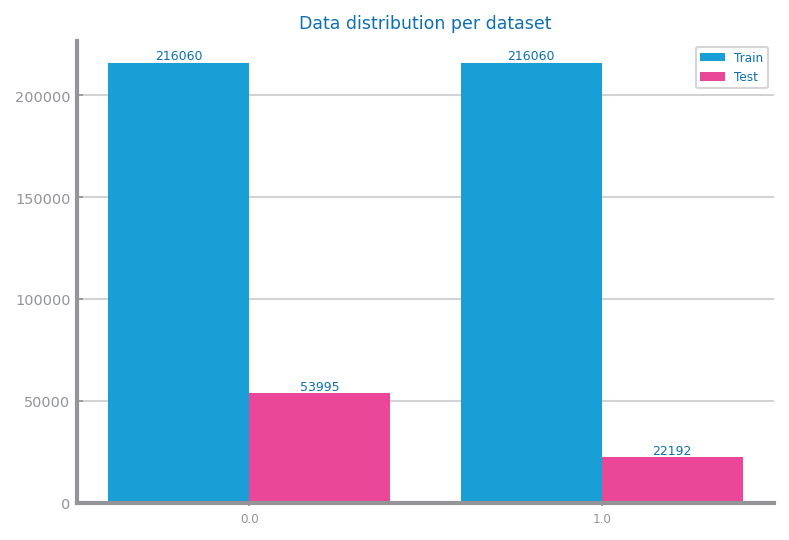

In [3]:
target = "CovidPos"

positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {}

values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

labels: list = list(train[target].unique())
labels.sort()

plt.figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
plt.show()

# Study

In [4]:
trnX = train.copy(deep=True)
trnY = trnX[target]
trnX = trnX.drop(target, axis=1)

tstX = test.copy(deep=True)
tstY = tstX[target]
tstX = tstX.drop(target, axis=1)

In [5]:
def knn_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, k_max: int=19, lag: int=2, metric='accuracy'
        ) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal['manhattan', 'euclidean', 'chebyshev']] = ['manhattan', 'euclidean', 'chebyshev']

    kvalues: list[int] = [i for i in range(1, k_max+1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {'name': 'KNN', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance: float = eval
                best_params['params'] = (k, d)
                best_model = clf
            print(f'KNN {d} k={k}')
        values[d] = y_tst_values
    print(f'KNN best with k={best_params['params'][0]} and {best_params['params'][1]}')
    plot_multiline_chart(kvalues, values, title=f'KNN Models ({metric})', xlabel='k', ylabel=metric, percentage=True)

    return best_model, best_params

## Default Hyperparams

KNN best with k=1 and manhattan


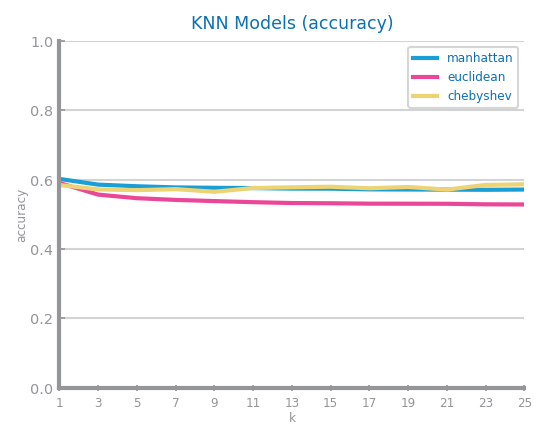

In [6]:
eval_metric = "accuracy"

plt.figure()
best_model_acc_1, params_acc_1 = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
plt.savefig(f"images/{file_tag}_knn_{eval_metric}_study.png")
plt.show()

KNN best with k=25 and euclidean


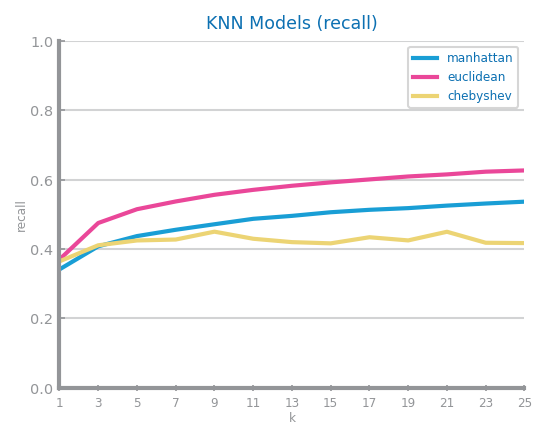

In [7]:
eval_metric = "recall"

plt.figure()
best_model_recall_1, params_recall_1 = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
plt.savefig(f"images/{file_tag}_knn_{eval_metric}_study.png")
plt.show()

# Best Model Performance

<Figure size 600x450 with 0 Axes>

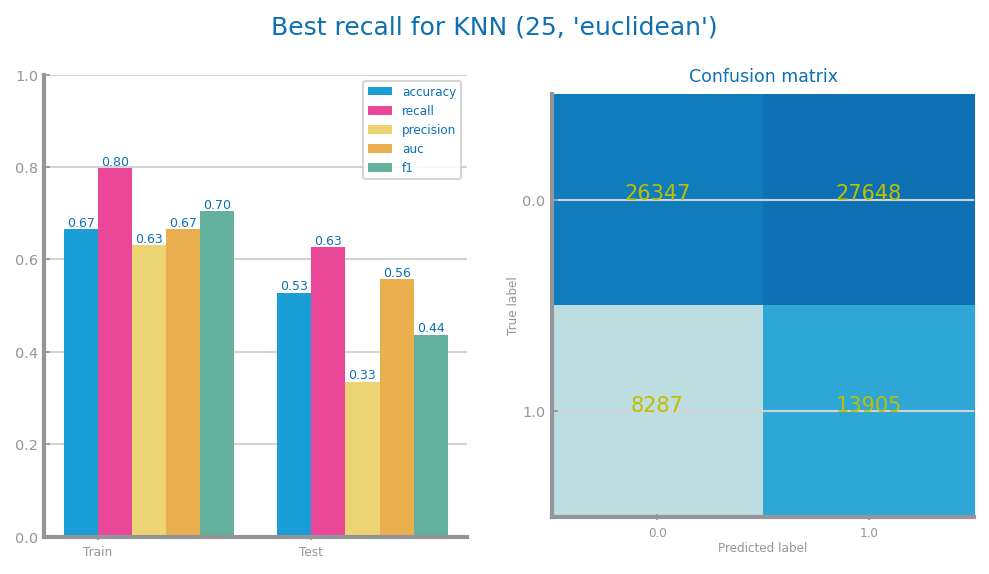

In [16]:
best_model = best_model_recall_1
best_params = params_recall_1

prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
plt.figure()
plot_evaluation_results(best_params, trnY, prd_trn, tstY, prd_tst, labels)
plt.savefig(f'images/{file_tag}_knn_k{best_params["params"][0]}_{best_params["params"][1]}_best_{best_params["metric"]}_eval.png')
plt.show()

# Overfitting study

Current k: 1
Current k: 3
Current k: 5
Current k: 7
Current k: 9
Current k: 11
Current k: 13
Current k: 15
Current k: 17
Current k: 19
Current k: 21
Current k: 23


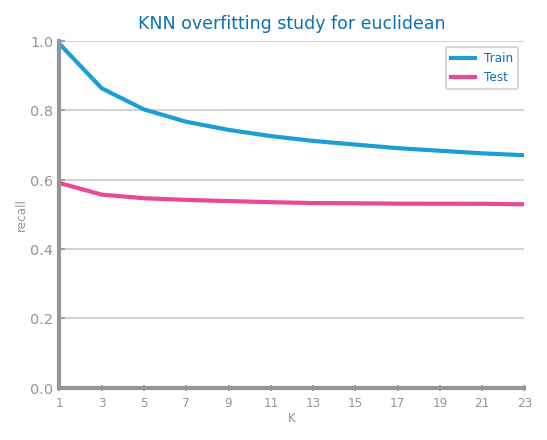

In [17]:
distance: Literal["manhattan", "euclidean", "chebyshev"] = best_params["params"][1]
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    print(f"Current k: {k}")
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

plt.figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
plt.savefig(f"images/{file_tag}_knn_overfitting.png")
plt.show()